# Gibbs Sampling: Full Diagnostics with ±1 Parameter Range
This notebook performs Gibbs sampling with summary statistics, model comparisons, triangle plots, and trace plots. All parameter plots use ±1 range around the true values for clarity and consistency.

In [1]:
import numpy as np
np.random.seed(42)

sigma_low = 0.001
sigma_high = 2.0
n_samples = 10000
burn_in = n_samples // 2

model_string = "y = m0*sin(m1*x)+m2*exp(-m3*x)"
param_names = ["m0", "m1", "m2", "m3"]
true_params = [3.0, 2.0, 5.0, 0.2]  # sigmoid height 3, slope 2, centered at x=5, small sinusoid
step_sizes = [0.5, 0.2, 0.2, 0.1]
init_guess = [1.0, 1.0, 5.0, 0.5]

def nonlinear_model(x, m):
    return m[0] / (1 + np.exp(-m[1]*(x - m[2]))) + m[3] * np.sin(x)

model_string = "y = m0*sin(m1*x)+m2*exp(-m3*x)"
true_params = [2.0, 2.5, 0.2, 0.5]
step_sizes = [0.1, 0.1, 0.05, 0.01]

def nonlinear_model(x, m):
    return m[0]*x - m[1]*x**2 + m[2]*x**3 + m[3]*(x/100)**4

step_sizes = [0.5, 0.2, 0.2, 0.1]
init_guess = [1.0, 1.0, 1.0, 1.0]
x_data = np.linspace(0, 10, 800)

param_names = ["m0", "m1", "m2", "m3"]

true_params = [2.0, 1, 0.5, 1.0]
step_sizes = [0.1, 0.1, 0.1, 0.1]
init_guess = [1.0, 1.0, 1.0, 1.0]
def nonlinear_model(x, m):
    return m[0] * np.sin(m[1] * x) + m[2] * np.exp(-m[3] * x)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def log_likelihood(p, x, y_obs, sigma):
    y_model = nonlinear_model(x, p)
    return -0.5 * np.sum(((y_obs - y_model) / sigma) ** 2)

def gibbs_sampler(x, y_obs, sigma, init_params, num_samples, step_size):
    samples = np.zeros((num_samples, len(init_params)))
    current = np.array(init_params)
    for i in range(num_samples):
        for j in range(len(init_params)):
            proposal = current.copy()
            proposal[j] += np.random.normal(0, step_size[j])
            if np.random.rand() < np.exp(
                log_likelihood(proposal, x, y_obs, sigma) - log_likelihood(current, x, y_obs, sigma)
            ):
                current[j] = proposal[j]
        samples[i, :] = current
    return samples


In [3]:
y_true = nonlinear_model(x_data, true_params)
y_low = y_true + np.random.normal(0, sigma_low, len(x_data))
y_high = y_true + np.random.normal(0, sigma_high, len(x_data))


In [4]:
samples_low = gibbs_sampler(x_data, y_low, sigma_low, init_guess, n_samples, step_sizes)
samples_high = gibbs_sampler(x_data, y_high, sigma_high, init_guess, n_samples, step_sizes)
posterior_low = samples_low[burn_in:]
posterior_high = samples_high[burn_in:]
mean_low = np.mean(posterior_low, axis=0)
mean_high = np.mean(posterior_high, axis=0)


In [5]:
print("LOW NOISE CASE")
print("Selected parameters:")
print(f"  True parameters: {true_params}")
print(f"  Initial guess:   {init_guess}")
print(f"  Noise sigma:     {sigma_low}")
print(f"  Step sizes:      {step_sizes}")
print(f"  Samples:         {n_samples} (burn-in: {burn_in})")
print("Inferred parameters (posterior mean):")
for name, true_val, est_val in zip(param_names, true_params, mean_low):
    print(f"  {name}: true = {true_val:.4f}, inferred = {est_val:.4f}")


LOW NOISE CASE
Selected parameters:
  True parameters: [2.0, 1, 0.5, 1.0]
  Initial guess:   [1.0, 1.0, 1.0, 1.0]
  Noise sigma:     0.001
  Step sizes:      [0.1, 0.1, 0.1, 0.1]
  Samples:         10000 (burn-in: 5000)
Inferred parameters (posterior mean):
  m0: true = 2.0000, inferred = 2.0000
  m1: true = 1.0000, inferred = 1.0000
  m2: true = 0.5000, inferred = 0.4998
  m3: true = 1.0000, inferred = 0.9997


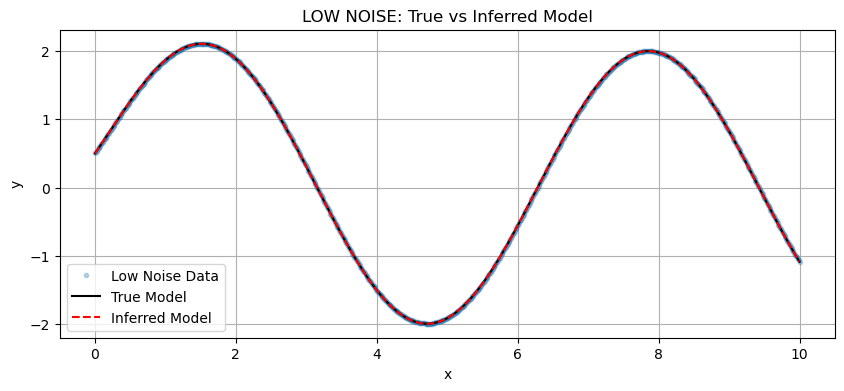

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_low, '.', alpha=0.3, label='Low Noise Data')
plt.plot(x_data, y_true, 'k-', label='True Model')
plt.plot(x_data, nonlinear_model(x_data, mean_low), 'r--', label='Inferred Model')
plt.title('LOW NOISE: True vs Inferred Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


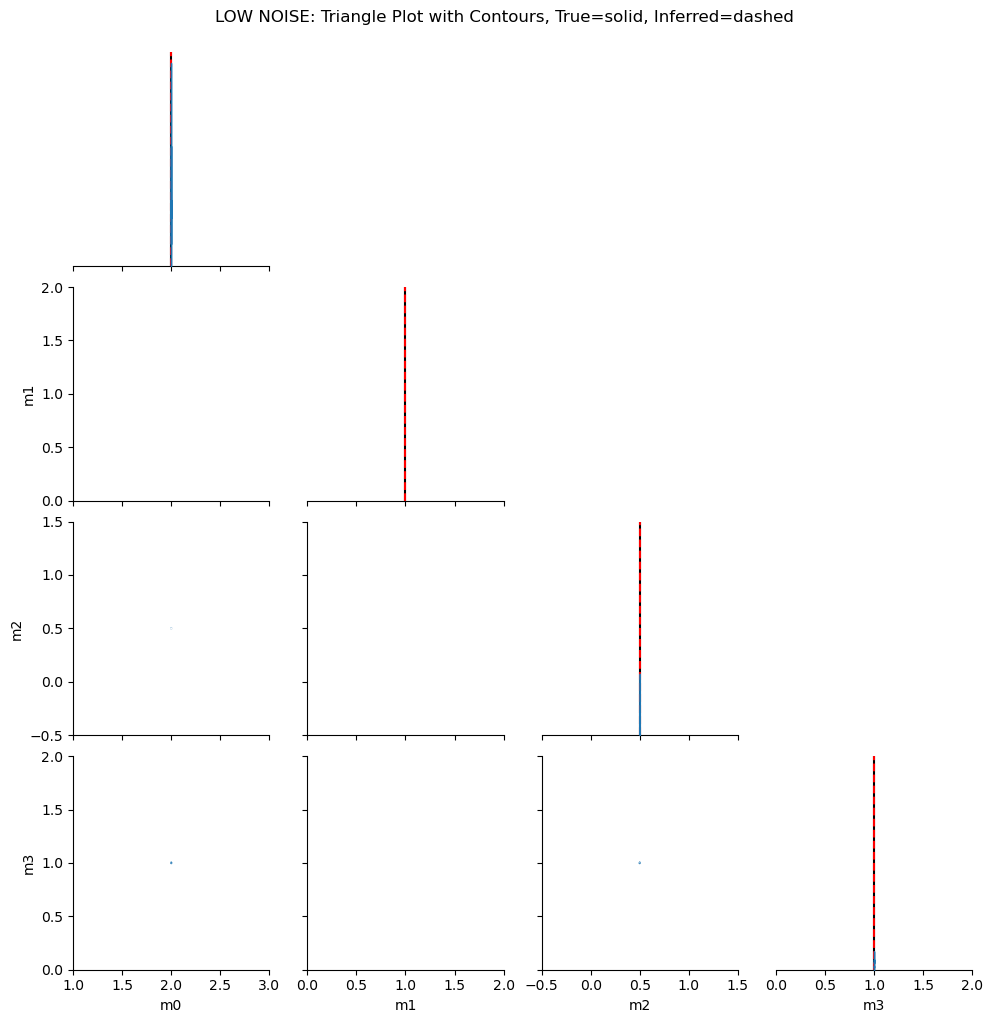

In [7]:
df = pd.DataFrame(posterior_low, columns=param_names)
lims = {p: (true_params[i] - 1.0, true_params[i] + 1.0) for i, p in enumerate(param_names)}
g = sns.PairGrid(df.iloc[::10], vars=param_names, corner=True)
g.map_lower(sns.kdeplot, levels=5, fill=False)
g.map_diag(sns.kdeplot, fill=True)
for i, p in enumerate(param_names):
    ax = g.axes[i, i]
    ax.axvline(true_params[i], color='k', linestyle='-')
    ax.axvline(mean_low[i], color='r', linestyle='--')
    ax.set_xlim(*lims[p])
    ax.set_ylim(*lims[p])
plt.suptitle("LOW NOISE: Triangle Plot with Contours, True=solid, Inferred=dashed", y=1.02)
plt.show()


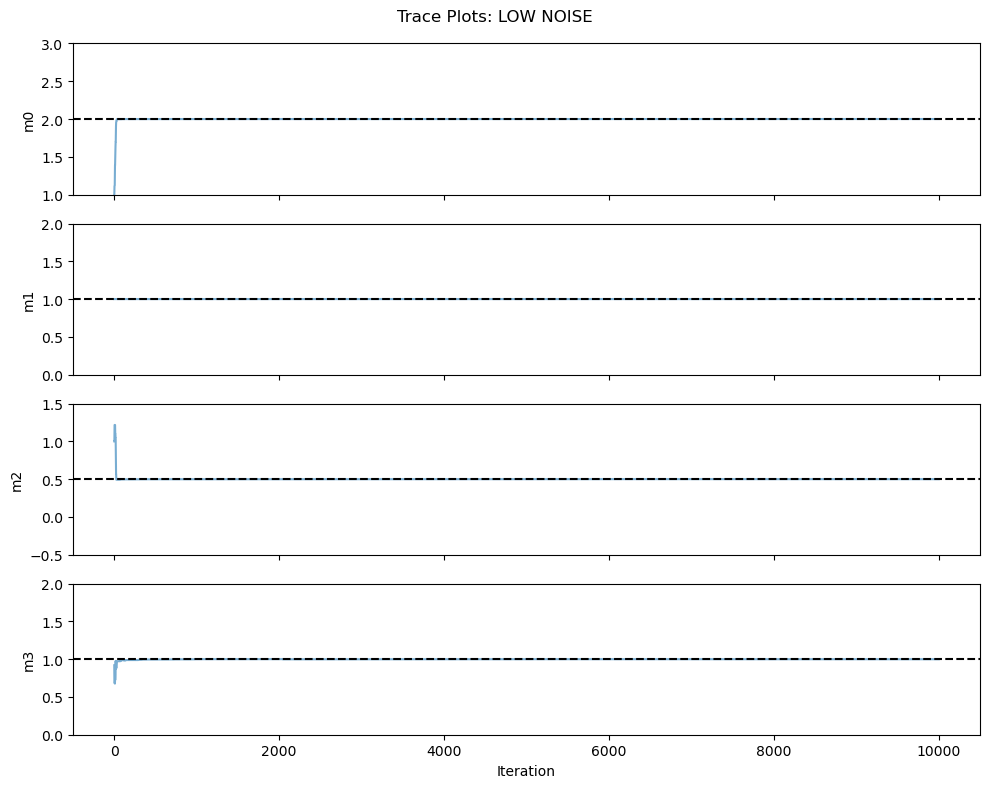

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
for i, name in enumerate(param_names):
    axes[i].plot(samples_low[:, i], alpha=0.6)
    axes[i].axhline(true_params[i], color='k', linestyle='--')
    axes[i].set_ylabel(name)
    axes[i].set_ylim(true_params[i] - 1.0, true_params[i] + 1.0)
axes[-1].set_xlabel("Iteration")
fig.suptitle("Trace Plots: LOW NOISE")
plt.tight_layout()
plt.show()


In [9]:
print("HIGH NOISE CASE")
print("Selected parameters:")
print(f"  True parameters: {true_params}")
print(f"  Initial guess:   {init_guess}")
print(f"  Noise sigma:     {sigma_high}")
print(f"  Step sizes:      {step_sizes}")
print(f"  Samples:         {n_samples} (burn-in: {burn_in})")
print("Inferred parameters (posterior mean):")
for name, true_val, est_val in zip(param_names, true_params, mean_high):
    print(f"  {name}: true = {true_val:.4f}, inferred = {est_val:.4f}")


HIGH NOISE CASE
Selected parameters:
  True parameters: [2.0, 1, 0.5, 1.0]
  Initial guess:   [1.0, 1.0, 1.0, 1.0]
  Noise sigma:     2.0
  Step sizes:      [0.1, 0.1, 0.1, 0.1]
  Samples:         10000 (burn-in: 5000)
Inferred parameters (posterior mean):
  m0: true = 2.0000, inferred = 2.1545
  m1: true = 1.0000, inferred = 0.9988
  m2: true = 0.5000, inferred = 0.7641
  m3: true = 1.0000, inferred = 0.8894


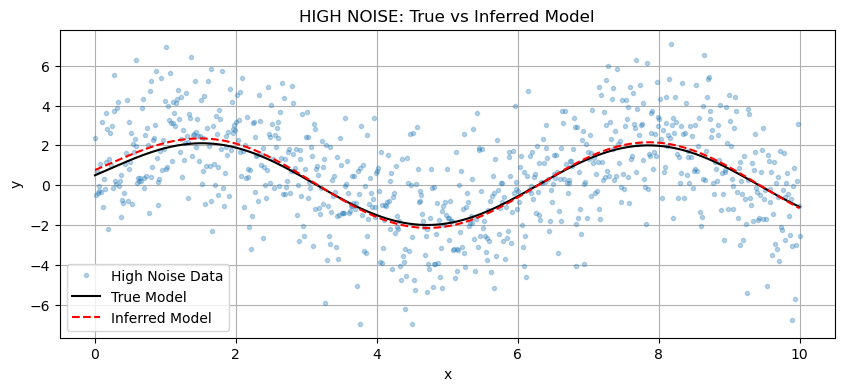

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_high, '.', alpha=0.3, label='High Noise Data')
plt.plot(x_data, y_true, 'k-', label='True Model')
plt.plot(x_data, nonlinear_model(x_data, mean_high), 'r--', label='Inferred Model')
plt.title('HIGH NOISE: True vs Inferred Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


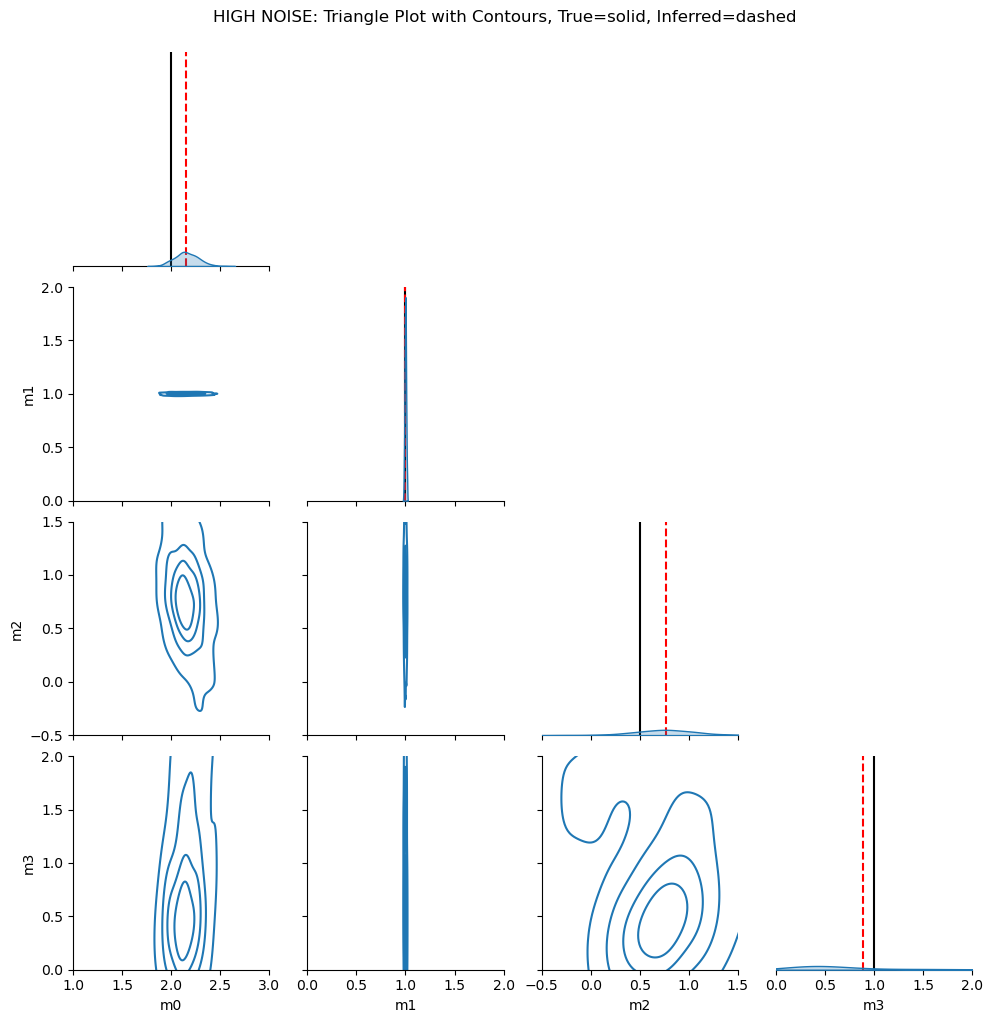

In [11]:
df = pd.DataFrame(posterior_high, columns=param_names)
lims = {p: (true_params[i] - 1.0, true_params[i] + 1.0) for i, p in enumerate(param_names)}
g = sns.PairGrid(df.iloc[::10], vars=param_names, corner=True)
g.map_lower(sns.kdeplot, levels=5, fill=False)
g.map_diag(sns.kdeplot, fill=True)
for i, p in enumerate(param_names):
    ax = g.axes[i, i]
    ax.axvline(true_params[i], color='k', linestyle='-')
    ax.axvline(mean_high[i], color='r', linestyle='--')
    ax.set_xlim(*lims[p])
    ax.set_ylim(*lims[p])
plt.suptitle("HIGH NOISE: Triangle Plot with Contours, True=solid, Inferred=dashed", y=1.02)
plt.show()


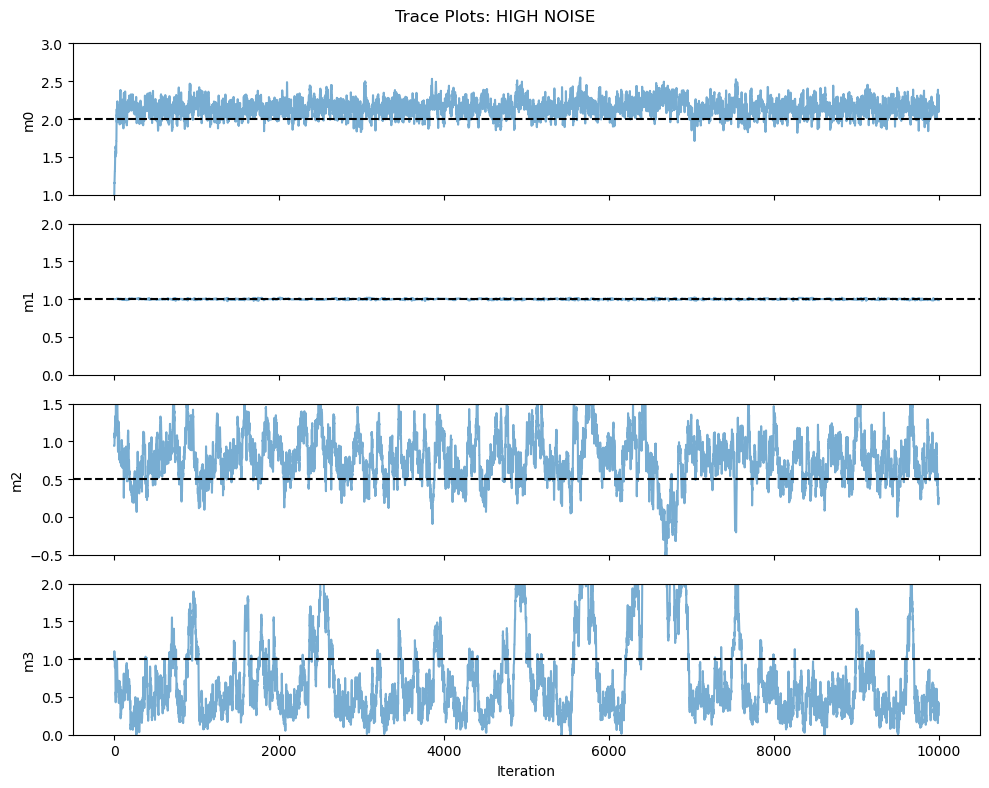

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
for i, name in enumerate(param_names):
    axes[i].plot(samples_high[:, i], alpha=0.6)
    axes[i].axhline(true_params[i], color='k', linestyle='--')
    axes[i].set_ylabel(name)
    axes[i].set_ylim(true_params[i] - 1.0, true_params[i] + 1.0)
axes[-1].set_xlabel("Iteration")
fig.suptitle("Trace Plots: HIGH NOISE")
plt.tight_layout()
plt.show()
